# What this notebook is about  
Basically continuing over from what I did with the Beyond_The_Haystack_Recreation_using_EDGAR notebook, I will be trying to recreate the same functionality but this time, using Lambda cloud API for GPU and llama-8b-instruct model.

# Work Flow for Local Testing and Lambda Execution

## Local Testing Checklist

Before deploying to Lambda, verify:

- [ ] **Test on 2-3 documents**: Run Cell 8 with `num_docs=2`
- [ ] **Validate 10 responses manually**: Check Cell 9 output for sensible answers
- [ ] **Check CSV export**: Confirm `edgar_niah_results_local.csv` has all columns
- [ ] **Verify plots render**: Cells 10-11 produce readable visualizations
- [ ] **Inspect failed cases**: Filter `results_df[results_df['is_correct'] == False]` to understand failure modes

## Lambda Execution Steps

1. **Upload notebook** to Lambda Cloud instance
2. **Install dependencies**:
   ```bash
   pip install transformers datasets pandas matplotlib seaborn torch tqdm
   ```
3. **Run Cells 1-11** (skip Cell 12 locally)
4. **Execute Cell 12** for full 50-document run
5. **Download results**:
   - `edgar_niah_results_full.csv`
   - `edgar_niah_j_curves.png`
   - `edgar_niah_heatmap.png`

## Expected Outcomes

✅ **Success criteria**:
- J-curves show **degradation** from standard → global shuffle
- **Easy questions** (state, year) maintain >70% accuracy until paragraph shuffle
- **Hard questions** (counts, names) degrade faster
- Clear difference between shuffle sensitivity across question types

❌ **Red flags**:
- All questions flat at 0% or 100% (model not learning)
- No difference between shuffle conditions (shuffling not working)
- Random noise patterns (questions too ambiguous)

In [ ]:
# If not using .env file/using lambda, just load HF_TOKEN manually by uncommenting it out and put it here
#%env HF_TOKEN=your_huggingface_token_here

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from tqdm.auto import tqdm
import warnings
import os

warnings.filterwarnings("ignore")

# Configuration
HF_TOKEN = os.getenv("HF_TOKEN")
print(HF_TOKEN)
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
DATASET_NAME = "c3po-ai/edgar-corpus"


# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

print("✓ Imports complete")

In [8]:
def get_device_and_dtype():
    """Auto-detect the best device and dtype."""
    if torch.cuda.is_available():
        return torch.device("cuda"), torch.float16
    elif torch.backends.mps.is_available():
        return torch.device("mps"), torch.float32  # MPS doesn't support bfloat16
    else:
        return torch.device("cpu"), torch.float32


print(f"CUDA available: {torch.cuda.is_available()}")
print(
    f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}"
)
device, dtype = get_device_and_dtype()

CUDA available: True
Device: NVIDIA A100-SXM4-40GB


In [14]:
from huggingface_hub import login

login(token=HF_TOKEN)
print("✓ Logged into Hugging Face")

print("Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)

if device.type == "cpu" or device.type == "mps":
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float32,
        device_map={"": device},
        low_cpu_mem_usage=True,
        token=HF_TOKEN
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=dtype,
        device_map="auto",
        token=HF_TOKEN
    )
model.eval()  # set to eval mode
print(f"✓ Model loaded: {MODEL_NAME}")
print(f"✓ Model device: {model.device}")
print(f"✓ Model dtype: {model.dtype}")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✓ Logged into Hugging Face
Loading tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

✓ Model loaded: meta-llama/Meta-Llama-3-8B-Instruct
✓ Model device: cuda:0
✓ Model dtype: torch.float16


In [19]:
print("Loading EDGAR dataset...")
train_url = "https://huggingface.co/datasets/c3po-ai/edgar-corpus/resolve/refs%2Fconvert%2Fparquet/year_2020/train/0000.parquet"
test_url = "https://huggingface.co/datasets/c3po-ai/edgar-corpus/resolve/refs%2Fconvert%2Fparquet/year_2020/test/0000.parquet"

train_dataset = load_dataset("parquet", data_files={"train": train_url}, split="train")
test_dataset = load_dataset("parquet", data_files={"test": test_url}, split="test")

print(f"Loaded {len(train_dataset)} train examples, {len(test_dataset)} test examples")

# Filter for documents with required sections
def has_required_sections(doc):
    return all(
        section in doc and doc[section] and len(doc[section].strip()) > 100
        for section in ["section_1", "section_2", "section_10"]
    )

# Combine and filter datasets
combined_dataset = train_dataset  # or concatenate_datasets([train_dataset, test_dataset]) if you want both
filtered_docs = [doc for doc in combined_dataset if has_required_sections(doc)]
print(f"✓ Loaded {len(filtered_docs)} documents with all required sections")

# Show sample document structure
sample_doc = filtered_docs[0]
print("\nSample document fields:")
for key in ["cik", "company_name", "filing_date", "section_1", "section_2", "section_10"]:
    if key in sample_doc:
        content = sample_doc[key]
        if isinstance(content, str):
            print(f"  {key}: {len(content)} chars")
        else:
            print(f"  {key}: {content}")

Loading EDGAR dataset...


year_2020/train/0000.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

year_2020/test/0000.parquet:   0%|          | 0.00/83.7M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loaded 2000 train examples, 685 test examples
✓ Loaded 1580 documents with all required sections

Sample document fields:
  cik: 6 chars
  section_1: 68190 chars
  section_2: 1848 chars
  section_10: 1404 chars


In [20]:
def shuffle_by_window(words, window_size):
    """Shuffle text within local windows"""
    result = []
    for i in range(0, len(words), window_size):
        window = words[i : i + window_size]
        random.shuffle(window)
        result.extend(window)
    return " ".join(result)


def create_shuffle_conditions(text, max_words=512):
    """Create all 5 shuffle conditions from text"""
    words = text.split()[:max_words]

    conditions = {
        "standard": " ".join(words),  # No shuffle
        "triad": shuffle_by_window(words.copy(), 3),
        "sentence": shuffle_by_window(words.copy(), 15),  # ~15 words per sentence
        "paragraph": shuffle_by_window(words.copy(), 75),  # ~75 words per paragraph
        "global": " ".join(random.sample(words, len(words))),  # Complete shuffle
    }

    return conditions


# Test shuffle functions
test_text = "The quick brown fox jumps over the lazy dog. " * 10
test_conditions = create_shuffle_conditions(test_text, max_words=50)
print("✓ Shuffle functions ready")
print(f"✓ Test conditions created: {list(test_conditions.keys())}")
print(f"✓ Standard length: {len(test_conditions['standard'].split())} words")

✓ Shuffle functions ready
✓ Test conditions created: ['standard', 'triad', 'sentence', 'paragraph', 'global']
✓ Standard length: 50 words


In [21]:
QUESTION_BANK = {
    "section_1": [
        {
            "id": "incorporation_state",
            "question": "In which U.S. state was this company incorporated?",
            "extract_regex": r"\b(Delaware|California|Nevada|Texas|Florida|New York|Delaware\.|DE|CA|NV|TX|FL|NY)\b",
            "difficulty": "Easy",
            "description": "State of incorporation - typically in first paragraph",
        },
        {
            "id": "incorporation_year",
            "question": "In what year was this company incorporated or founded?",
            "extract_regex": r"\b(19\d{2}|20\d{2})\b",
            "difficulty": "Easy",
            "description": "Year of incorporation - usually near state mention",
        },
        {
            "id": "business_description",
            "question": "What is the primary business or industry of this company? Answer in one phrase.",
            "extract_regex": r"\b(technology|software|pharmaceutical|retail|manufacturing|financial|services|healthcare|energy|telecommunications)\b",
            "difficulty": "Medium",
            "description": "Industry classification - requires understanding context",
        },
        {
            "id": "fiscal_year_end",
            "question": "What is the fiscal year end month for this company?",
            "extract_regex": r"\b(January|February|March|April|May|June|July|August|September|October|November|December)\b",
            "difficulty": "Medium",
            "description": "Fiscal year end - often mentioned in Business section",
        },
    ],
    "section_2": [
        {
            "id": "headquarters_city",
            "question": "In which city is the company headquarters located?",
            "extract_regex": r"\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)?),\s*[A-Z]{2}\b",
            "difficulty": "Easy",
            "description": "HQ city - usually explicitly stated in Properties",
        },
        {
            "id": "headquarters_state",
            "question": "In which U.S. state is the company headquarters located?",
            "extract_regex": r"\b(Alabama|Alaska|Arizona|Arkansas|California|Colorado|Delaware|Florida|Georgia|Illinois|New York|Texas|AL|AK|AZ|CA|CO|DE|FL|GA|IL|NY|TX)\b",
            "difficulty": "Easy",
            "description": "HQ state - paired with city information",
        },
        {
            "id": "property_count",
            "question": "How many facilities or properties does the company operate? Provide a number.",
            "extract_regex": r"\b(\d+)\s+(facilities|properties|locations|offices|plants)\b",
            "difficulty": "Hard",
            "description": "Facility count - requires aggregating information",
        },
    ],
    "section_10": [
        {
            "id": "ceo_name",
            "question": "Who is the Chief Executive Officer (CEO) of this company? Provide full name.",
            "extract_regex": r"\b([A-Z][a-z]+\s+[A-Z][a-z]+)\b.*?\b(CEO|Chief Executive Officer)\b",
            "difficulty": "Medium",
            "description": "CEO name - usually in director listings",
        },
        {
            "id": "board_size",
            "question": "How many directors are on the board of directors? Provide a number.",
            "extract_regex": r"\b(\d+)\s+(directors?|members?)\b",
            "difficulty": "Medium",
            "description": "Board size - requires counting or finding explicit count",
        },
    ],
}

# Print question bank summary
total_questions = sum(len(questions) for questions in QUESTION_BANK.values())
print(f"✓ Question bank defined: {total_questions} total questions")
for section, questions in QUESTION_BANK.items():
    print(f"  {section}: {len(questions)} questions")
    for q in questions:
        print(f"    - {q['id']} ({q['difficulty']}): {q['description']}")

✓ Question bank defined: 9 total questions
  section_1: 4 questions
    - incorporation_state (Easy): State of incorporation - typically in first paragraph
    - incorporation_year (Easy): Year of incorporation - usually near state mention
    - business_description (Medium): Industry classification - requires understanding context
    - fiscal_year_end (Medium): Fiscal year end - often mentioned in Business section
  section_2: 3 questions
    - headquarters_city (Easy): HQ city - usually explicitly stated in Properties
    - headquarters_state (Easy): HQ state - paired with city information
    - property_count (Hard): Facility count - requires aggregating information
  section_10: 2 questions
    - ceo_name (Medium): CEO name - usually in director listings
    - board_size (Medium): Board size - requires counting or finding explicit count


In [22]:
def query_llama(document_text, question, max_new_tokens=50):
    """Query Llama-3 model with proper chat template"""

    messages = [
        {
            "role": "system",
            "content": "You are analyzing a financial document. Answer precisely based only on the provided text. Be concise.",
        },
        {
            "role": "user",
            "content": f"Document excerpt:\n{document_text}\n\nQuestion: {question}\n\nAnswer:",
        },
    ]

    # Apply chat template
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Tokenize
    inputs = tokenizer(
        prompt, return_tensors="pt", truncation=True, max_length=2048
    ).to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.0,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode only the generated part
    generated_ids = outputs[0][inputs["input_ids"].shape[1] :]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return response.strip()


# Test query function
test_doc = "Apple Inc. was incorporated in California in 1977. The company develops consumer electronics."
test_q = "In which state was this company incorporated?"
test_response = query_llama(test_doc, test_q)
print("✓ Query function ready")
print(f"Test question: {test_q}")
print(f"Test response: {test_response}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ Query function ready
Test question: In which state was this company incorporated?
Test response: California.


In [23]:
def check_answer(response, ground_truth_text, extract_regex):
    """Check if response matches expected answer using regex"""

    # Extract expected answer from ground truth
    ground_truth_match = re.search(extract_regex, ground_truth_text, re.IGNORECASE)
    if not ground_truth_match:
        return False, None, None

    expected_answer = ground_truth_match.group(0)

    # Check if response contains the expected answer
    response_match = re.search(extract_regex, response, re.IGNORECASE)
    if response_match:
        response_answer = response_match.group(0)
        # Fuzzy matching for state abbreviations
        is_correct = (
            expected_answer.lower() == response_answer.lower()
            or expected_answer[:2].lower()
            == response_answer[:2].lower()  # State abbreviations
        )
        return is_correct, expected_answer, response_answer

    return False, expected_answer, None


# Test validation
test_gt = "The company was incorporated in Delaware in 1995."
test_resp1 = "The company was incorporated in Delaware."
test_resp2 = "The company was incorporated in California."
regex = r"\b(Delaware|California|Nevada|DE|CA|NV)\b"

correct1, exp1, resp1 = check_answer(test_resp1, test_gt, regex)
correct2, exp2, resp2 = check_answer(test_resp2, test_gt, regex)

print("✓ Validation function ready")
print(f"Test 1 - Expected: {exp1}, Response: {resp1}, Correct: {correct1}")
print(f"Test 2 - Expected: {exp2}, Response: {resp2}, Correct: {correct2}")

✓ Validation function ready
Test 1 - Expected: Delaware, Response: Delaware, Correct: True
Test 2 - Expected: Delaware, Response: California, Correct: False


In [24]:
def run_experiment(num_docs=3, max_words=512):
    """Run full NIAH experiment across documents and shuffle conditions"""

    results = []
    shuffle_order = ["standard", "triad", "sentence", "paragraph", "global"]

    print(f"Starting experiment on {num_docs} documents...")

    for doc_idx in tqdm(range(num_docs), desc="Documents"):
        doc = filtered_docs[doc_idx]

        for section_name, questions in QUESTION_BANK.items():
            section_text = doc[section_name]

            for question_data in tqdm(questions, desc=f"  {section_name}", leave=False):
                # Create shuffle conditions
                shuffle_conditions = create_shuffle_conditions(section_text, max_words)

                for condition_name in shuffle_order:
                    shuffled_text = shuffle_conditions[condition_name]

                    # Query model
                    response = query_llama(shuffled_text, question_data["question"])

                    # Validate answer
                    is_correct, expected, extracted = check_answer(
                        response,
                        section_text,  # Check against original text
                        question_data["extract_regex"],
                    )

                    # Store result
                    results.append(
                        {
                            "doc_idx": doc_idx,
                            "company_name": doc.get("company_name", "Unknown"),
                            "section": section_name,
                            "question_id": question_data["id"],
                            "question": question_data["question"],
                            "difficulty": question_data["difficulty"],
                            "shuffle_condition": condition_name,
                            "response": response,
                            "expected_answer": expected,
                            "extracted_answer": extracted,
                            "is_correct": is_correct,
                        }
                    )

    return pd.DataFrame(results)


# Run experiment (start with 3 docs for local testing)
print("Running LOCAL TEST on 3 documents...")
results_df = run_experiment(num_docs=3, max_words=512)

print("\n✓ Experiment complete!")
print(f"Total queries: {len(results_df)}")
print(f"Overall accuracy: {results_df['is_correct'].mean():.2%}")

# Save results
results_df.to_csv("edgar_niah_results_local.csv", index=False)
print("✓ Results saved to edgar_niah_results_local.csv")

Running LOCAL TEST on 3 documents...
Starting experiment on 3 documents...


Documents:   0%|          | 0/3 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]


✓ Experiment complete!
Total queries: 135
Overall accuracy: 20.74%
✓ Results saved to edgar_niah_results_local.csv


In [26]:
# Calculate accuracy by shuffle condition
shuffle_accuracy = results_df.groupby("shuffle_condition")["is_correct"].mean()
print("\n=== ACCURACY BY SHUFFLE CONDITION ===")
for condition in ["standard", "triad", "sentence", "paragraph", "global"]:
    acc = shuffle_accuracy[condition]
    print(f"{condition:12s}: {acc:6.2%}")

# Calculate accuracy by question
print("\n=== ACCURACY BY QUESTION ===")
question_accuracy = results_df.groupby(["section", "question_id", "difficulty"])[
    "is_correct"
].mean()
for (section, q_id, diff), acc in question_accuracy.items():
    print(f"{section:12s} | {q_id:25s} ({diff:6s}): {acc:6.2%}")

# Show sample responses
print("\n=== SAMPLE RESPONSES ===")
for _, row in results_df.head(10).iterrows():
    print(f"\nQ: {row['question']}")
    print(f"Condition: {row['shuffle_condition']}")
    print(f"Response: {row['response'][:100]}...")
    print(f"Correct: {row['is_correct']} (Expected: {row['expected_answer']})")


=== ACCURACY BY SHUFFLE CONDITION ===
standard    : 18.52%
triad       : 25.93%
sentence    : 25.93%
paragraph   : 22.22%
global      : 14.81%

=== ACCURACY BY QUESTION ===
section_1    | business_description      (Medium): 33.33%
section_1    | fiscal_year_end           (Medium):  0.00%
section_1    | incorporation_state       (Easy  ): 33.33%
section_1    | incorporation_year        (Easy  ): 60.00%
section_10   | board_size                (Medium):  0.00%
section_10   | ceo_name                  (Medium):  6.67%
section_2    | headquarters_city         (Easy  ):  0.00%
section_2    | headquarters_state        (Easy  ): 60.00%
section_2    | property_count            (Hard  ):  0.00%

=== SAMPLE RESPONSES ===

Q: In which U.S. state was this company incorporated?
Condition: standard
Response: Vermont....
Correct: False (Expected: Delaware)

Q: In which U.S. state was this company incorporated?
Condition: triad
Response: Vermont....
Correct: False (Expected: Delaware)

Q: In which U.

✓ J-curve plots saved to edgar_niah_j_curves.png


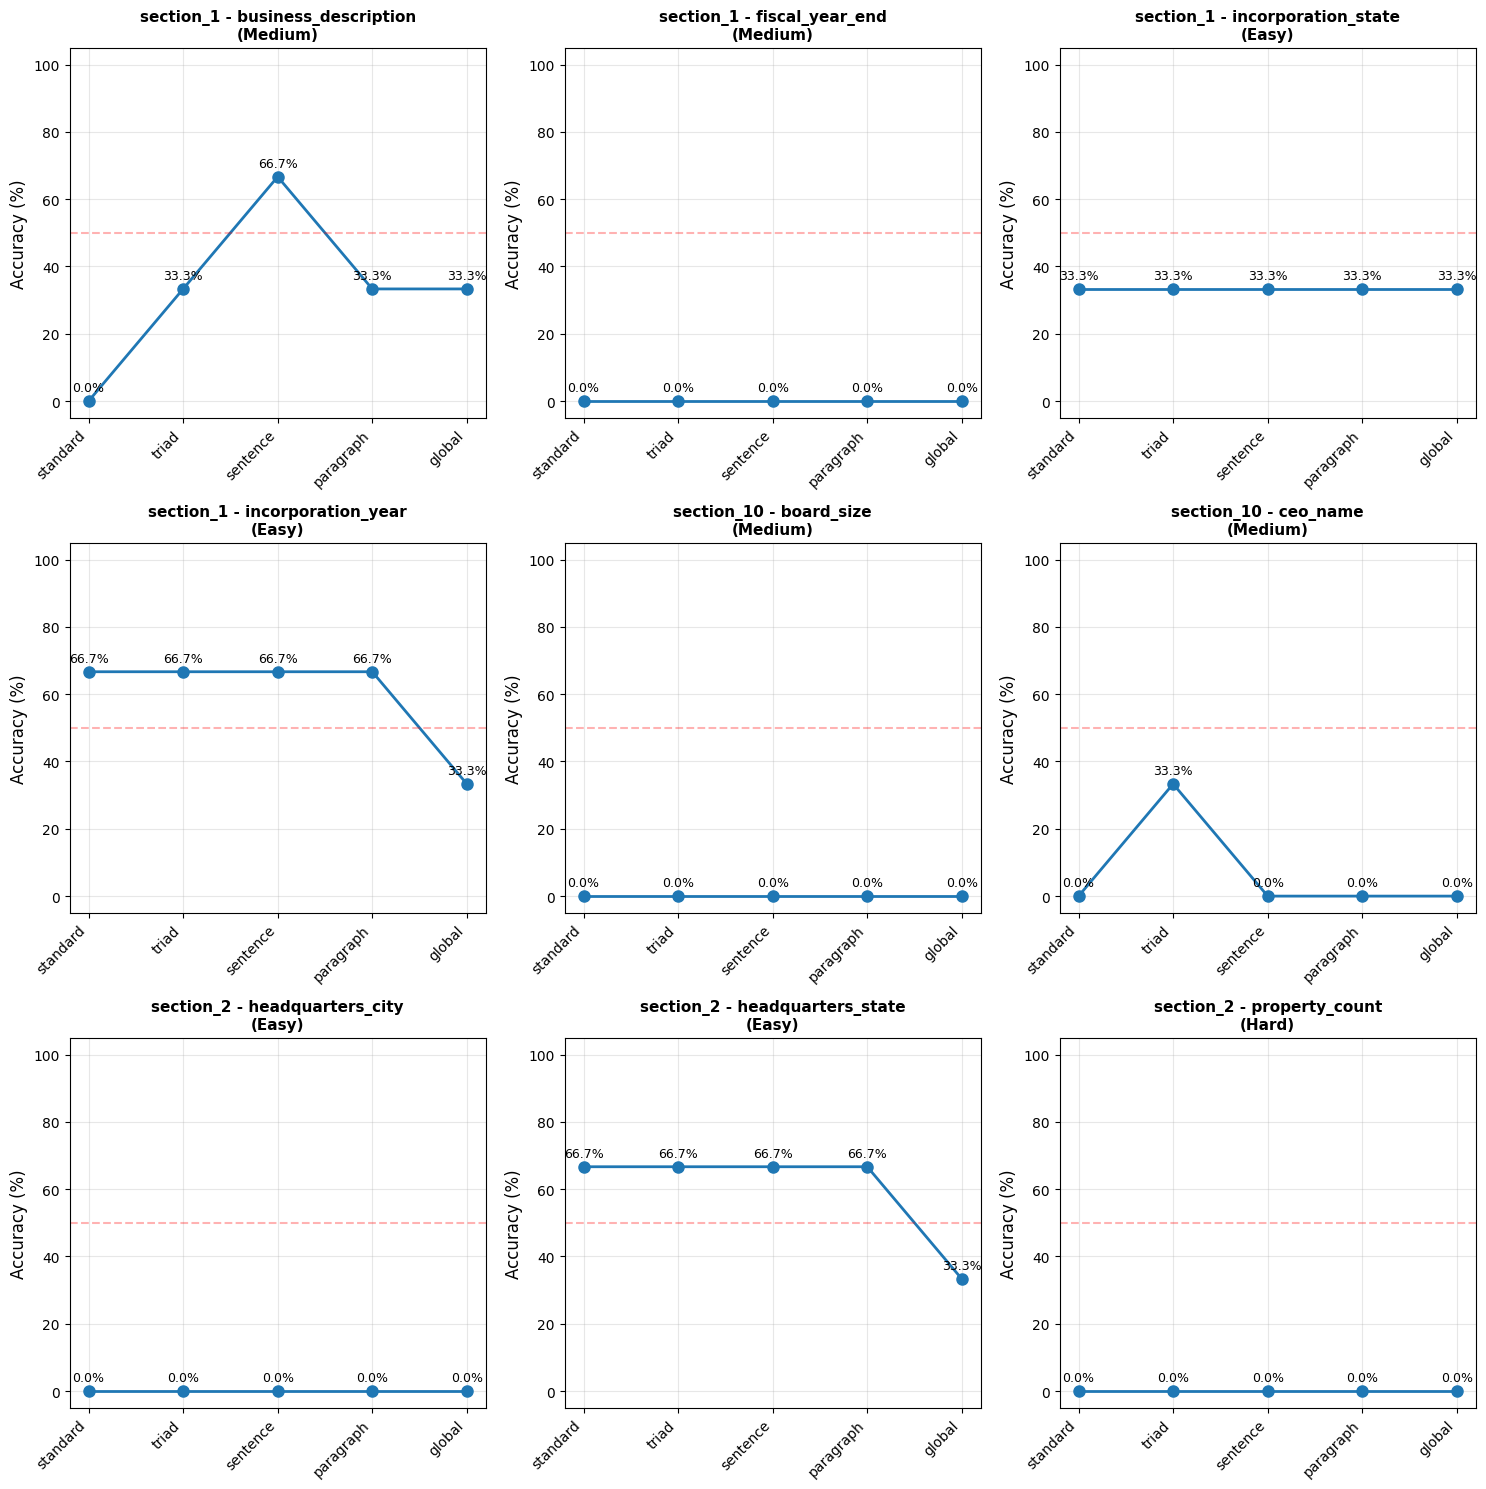

In [27]:
def plot_j_curves(results_df):
    """Create J-curve plots for each question type"""

    shuffle_order = ["standard", "triad", "sentence", "paragraph", "global"]

    # Get unique questions
    questions = (
        results_df.groupby(["section", "question_id", "difficulty"])
        .size()
        .reset_index()[["section", "question_id", "difficulty"]]
    )

    # Calculate grid size
    n_questions = len(questions)
    n_cols = 3
    n_rows = (n_questions + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_questions > 1 else [axes]

    for idx, (_, question_info) in enumerate(questions.iterrows()):
        section = question_info["section"]
        q_id = question_info["question_id"]
        difficulty = question_info["difficulty"]

        # Filter data for this question
        question_data = results_df[
            (results_df["section"] == section) & (results_df["question_id"] == q_id)
        ]

        # Calculate accuracy per shuffle condition
        accuracies = []
        for condition in shuffle_order:
            acc = question_data[question_data["shuffle_condition"] == condition][
                "is_correct"
            ].mean()
            accuracies.append(acc * 100)  # Convert to percentage

        # Plot
        ax = axes[idx]
        ax.plot(
            range(len(shuffle_order)), accuracies, marker="o", linewidth=2, markersize=8
        )
        ax.set_xticks(range(len(shuffle_order)))
        ax.set_xticklabels(shuffle_order, rotation=45, ha="right")
        ax.set_ylim(-5, 105)
        ax.set_ylabel("Accuracy (%)", fontsize=12)
        ax.set_title(
            f"{section} - {q_id}\n({difficulty})", fontsize=11, fontweight="bold"
        )
        ax.grid(True, alpha=0.3)
        ax.axhline(y=50, color="r", linestyle="--", alpha=0.3, label="50% baseline")

        # Add value labels
        for i, acc in enumerate(accuracies):
            ax.text(i, acc + 3, f"{acc:.1f}%", ha="center", fontsize=9)

    # Hide unused subplots
    for idx in range(n_questions, len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.savefig("edgar_niah_j_curves.png", dpi=300, bbox_inches="tight")
    print("✓ J-curve plots saved to edgar_niah_j_curves.png")
    plt.show()


# Generate plots
plot_j_curves(results_df)

LAMBDA RUN: Processing 50 documents...
Estimated time: ~45-60 minutes on A10 GPU
Estimated cost: ~$0.75
Starting experiment on 50 documents...


Documents:   0%|          | 0/50 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

  section_1:   0%|          | 0/4 [00:00<?, ?it/s]

  section_2:   0%|          | 0/3 [00:00<?, ?it/s]

  section_10:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Full results saved: 2250 queries
✓ J-curve plots saved to edgar_niah_j_curves.png


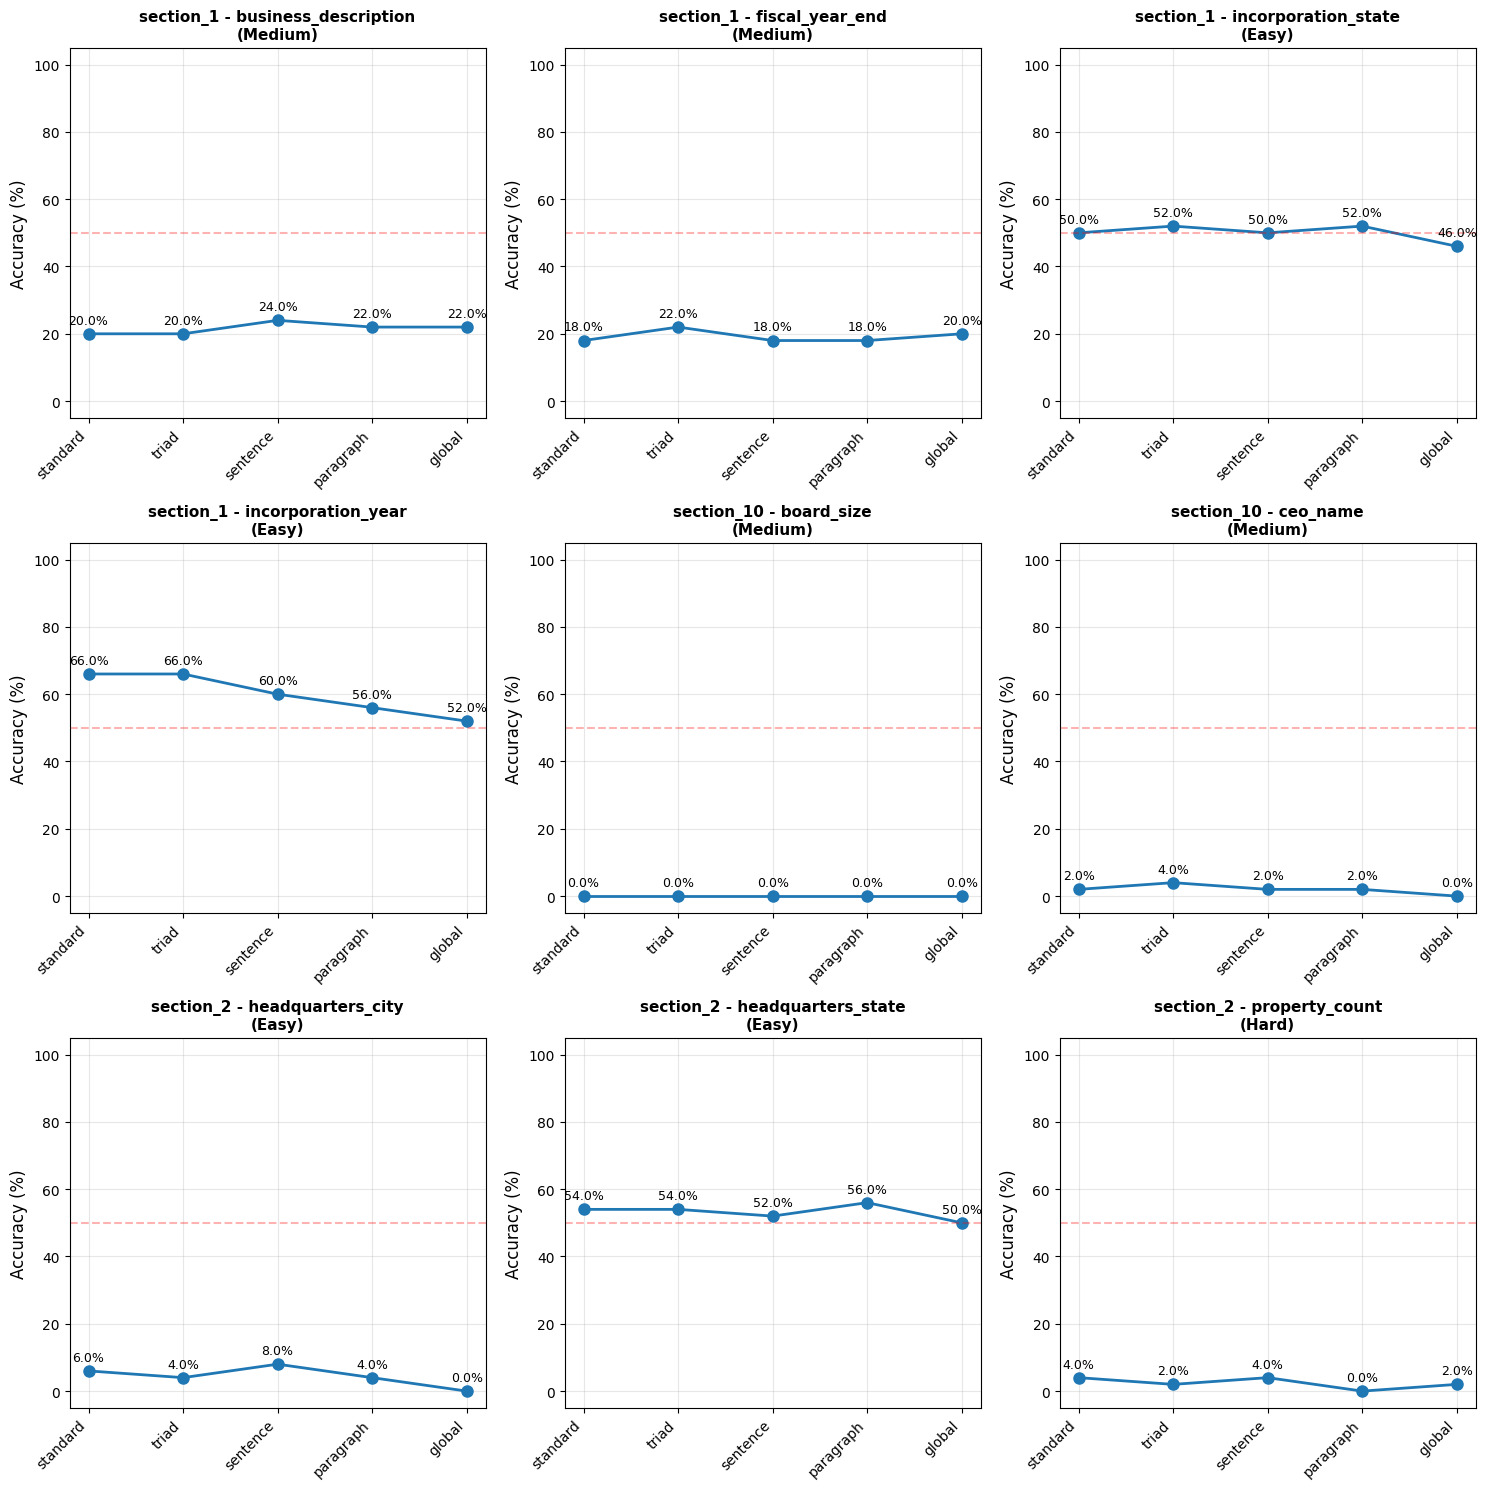


=== FINAL RESULTS (50 Documents) ===
shuffle_condition
global       21.333333
paragraph    23.333333
sentence     24.222222
standard     24.444444
triad        24.888889
Name: is_correct, dtype: float64


In [29]:
# LAMBDA EXECUTION: Run on 50 documents
NUM_DOCS_LAMBDA = 50

print(f"LAMBDA RUN: Processing {NUM_DOCS_LAMBDA} documents...")
print("Estimated time: ~45-60 minutes on A10 GPU")
print("Estimated cost: ~$0.75")

results_df_full = run_experiment(num_docs=NUM_DOCS_LAMBDA, max_words=512)

# Save immediately
results_df_full.to_csv("edgar_niah_results_full.csv", index=False)
print(f"✓ Full results saved: {len(results_df_full)} queries")

# Generate visualizations
plot_j_curves(results_df_full)

# Final summary
print("\n=== FINAL RESULTS (50 Documents) ===")
print(results_df_full.groupby("shuffle_condition")["is_correct"].mean() * 100)